# Renda-Classificação

## Introdução

O objetivo desse projeto é prever a renda de um grupo familiar utilizando informações relacionadas a sua residência. Trata-se portanto de um projeto de **regressão supervisionado offline**. 

## Extração dos dados

Os dados utilizados são do **Censo 2000** realizado pelo IBGE e mantido na [Base dos Dados](https://basedosdados.org/dataset/br-ibge-censo-demografico?bdm_table=microdados_domicilio_2000). Informações sobre a metodologia do Censo e sobre a base de dados estão na pasta `materiais`. A extração será realizada utilizando SQL utilizando a API do **BigQuery**.

In [68]:
# Consulta

import os
import pandas as pd
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'renda-censo-regressao-0d5cd82b3cac.json'

client = bigquery.Client()

query = """
        SELECT sigla_uf, id_municipio, situacao_domicilio, v0202 AS tipo_domicilio, v0205 AS condicao_domicilio, v0203 AS comodos, v0209 AS banheiros, v0207 AS agua, v0213 AS iluminacao, v0214 AS radio, v0215 AS geladeira, v0216 AS videocassete, v0217 AS maquina_lavar, v0218 AS microondas, v0219 as telefone, v0220 as computador, v0221 as televisores, v0222 as automoveis, v0223 as ar_condicionado, v7100 as iluminacao_publica, v1113 as pavimentacao, v0212 AS coleta_lixo, v0211 AS esgotamento, v7204 AS morador_dormitorio, v7100 AS moradores, v0110 AS homens, v0111 AS mulheres, v7616 AS rendimento
        FROM `basedosdados.br_ibge_censo_demografico.microdados_domicilio_2000`
        WHERE (v7616 IS NOT NULL) AND (v7616 > 0) AND v0201 = 1
        ORDER BY RAND() 
        LIMIT 100000;
        """

df_raw = client.query(query).to_dataframe()
df_raw.to_csv('data/df_raw.csv', index=False)

In [69]:
df_raw.head()

,sigla_uf,id_municipio,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,banheiros,agua,iluminacao,radio,...,ar_condicionado,iluminacao_publica,pavimentacao,coleta_lixo,esgotamento,morador_dormitorio,moradores,homens,mulheres,rendimento
0,SC,4208005,1,1,1,9,2,1,1,1,...,0,7,<NA>,1,1,1.8,7,4,3,3630
1,SP,3509502,1,2,1,3,1,1,1,1,...,0,1,1,1,1,1.0,1,0,1,623
2,BA,2914703,1,1,1,5,1,1,1,1,...,0,3,3,1,3,1.5,3,2,1,502
3,DF,5300108,1,1,2,5,1,1,1,2,...,0,2,1,1,1,1.0,2,1,1,300
4,MA,2105153,1,1,1,4,0,1,1,1,...,0,5,3,3,<NA>,2.5,5,1,4,200


In [70]:
df_raw.isna().sum()

sigla_uf                 0
id_municipio             0
situacao_domicilio       0
tipo_domicilio           0
condicao_domicilio       0
comodos                  0
banheiros                0
agua                     0
iluminacao               0
radio                    0
geladeira                0
videocassete             0
maquina_lavar            0
microondas               0
telefone                 0
computador               0
televisores              0
automoveis               0
ar_condicionado          0
iluminacao_publica       0
pavimentacao          8050
coleta_lixo              0
esgotamento           8530
morador_dormitorio       0
moradores                0
homens                   0
mulheres                 0
rendimento               0
dtype: int64

In [71]:
df_raw.shape

(100000, 28)

## Colunas

Coluna       | Tipo  | Descrição
-------------|-------|-------------------------------
sigla_uf     |str    | Sigla da Unidade da Federação
id_municipio |str    | ID de 7 dígitos do IBGE
situacao_domicilio | int64 |

In [1]:
# sigla_uf	STRING	Sigla da Unidade da Federação
# id_municipio	STRING	ID Município - IBGE 7 Dígitos
# situacao_domicilio	INT64	Situação do domicílio
# v0110	INT64	Total de homens
# v0111	INT64	Total de mulheres
# v0202	INT64	Tipo do domicílio
# v0203	INT64	Total de cômodos
# v0205	INT64	Condição do domicílio
# v0207	INT64	Forma de abastecimento de água
# v0209	INT64	Total de banheiros
# v0212	INT64	Coleta de lixo
# v0213	INT64	Iluminação elétrica
# v0214	INT64	Existência de rádio
# v0215	INT64	Existência de geladeira ou freezer
# v0216	INT64	Existência de videocassete
# v0217	INT64	Existência de máquina de lavar roupa
# v0218	INT64	Existência de forno de microondas
# v0219	INT64	Existência de linha telefônica instalada
# v0220	INT64	Existência de microcomputador
# v0221	INT64	Quantidade existente de televisores
# v0222	INT64	Quantidade existente de automóveis para uso particular
# v0223	INT64	Quantidade existente de aparelhos de ar condicionado
# v7100	INT64	Total de moradores no domicílio
# v1112	INT64	Existência de iluminação pública
# v1113	INT64	Existência de calçamento/pavimentação

# v7616	INT64	Total de rendimentos do domicílio particular

## Problema de negócio e avaliação do modelo

## Explorando os dados

In [10]:
# Importando bibliotecas

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [95]:
df_raw = pd.read_csv('data/df_raw.csv')

In [96]:
df_raw.head()

,sigla_uf,id_municipio,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,banheiros,agua,iluminacao,radio,...,ar_condicionado,iluminacao_publica,pavimentacao,coleta_lixo,esgotamento,morador_dormitorio,moradores,homens,mulheres,rendimento
0,SC,4208005,1,1,1,9,2,1,1,1,...,0,7,NaN,1,1.0,1.8,7,4,3,3630
1,SP,3509502,1,2,1,3,1,1,1,1,...,0,1,1.0,1,1.0,1.0,1,0,1,623
2,BA,2914703,1,1,1,5,1,1,1,1,...,0,3,3.0,1,3.0,1.5,3,2,1,502
3,DF,5300108,1,1,2,5,1,1,1,2,...,0,2,1.0,1,1.0,1.0,2,1,1,300
4,MA,2105153,1,1,1,4,0,1,1,1,...,0,5,3.0,3,NaN,2.5,5,1,4,200


In [97]:
# Dropando NA

df = df_raw.dropna()

In [98]:
df.shape

(84140, 28)

## Pre-processamento

In [99]:
df['situacao_domicilio'] = df['situacao_domicilio'].map({1:'urbano', 2:'rural'})

<ipython-input-99-ffb7919e2730>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['situacao_domicilio'] = df['situacao_domicilio'].map({1:'urbano', 2:'rural'})


In [100]:
df['tipo_domicilio'] = df['tipo_domicilio'].map({1:'casa', 2:'apartamento', 3:'comodo'})

<ipython-input-100-5744f5f8aca3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tipo_domicilio'] = df['tipo_domicilio'].map({1:'casa', 2:'apartamento', 3:'comodo'})


In [101]:
df['condicao_domicilio'] = df['condicao_domicilio'].map({1:'proprio pago',
                                                         2:'proprio pagando',
                                                         3:'alugado',
                                                         4:'cedido por empregador.',
                                                         5:'cedido',
                                                         6:'outro'})

<ipython-input-101-9615ff2e2bdc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['condicao_domicilio'] = df['condicao_domicilio'].map({1:'proprio pago',


In [118]:
df['id_municipio'].value_counts()

3550308    5713
3304557    3335
3106200    1267
2927408    1220
5300108    1090
           ... 
3163003       1
1711951       1
2512077       1
1507755       1
2111631       1
Name: id_municipio, Length: 4845, dtype: int64

In [102]:
df.head()

,sigla_uf,id_municipio,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,banheiros,agua,iluminacao,radio,...,ar_condicionado,iluminacao_publica,pavimentacao,coleta_lixo,esgotamento,morador_dormitorio,moradores,homens,mulheres,rendimento
1,SP,3509502,urbano,apartamento,proprio pago,3,1,1,1,1,...,0,1,1.0,1,1.0,1.0,1,0,1,623
2,BA,2914703,urbano,casa,proprio pago,5,1,1,1,1,...,0,3,3.0,1,3.0,1.5,3,2,1,502
3,DF,5300108,urbano,casa,proprio pagando,5,1,1,1,2,...,0,2,1.0,1,1.0,1.0,2,1,1,300
5,PI,2209005,urbano,casa,proprio pago,9,2,1,1,1,...,0,1,1.0,2,2.0,1.0,1,0,1,620
7,PR,4106902,urbano,casa,proprio pagando,5,1,1,1,1,...,0,4,1.0,1,1.0,2.0,4,1,3,1180


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84140 entries, 1 to 99999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sigla_uf            84140 non-null  object 
 1   id_municipio        84140 non-null  int64  
 2   situacao_domicilio  84140 non-null  object 
 3   tipo_domicilio      84140 non-null  object 
 4   condicao_domicilio  84140 non-null  object 
 5   comodos             84140 non-null  int64  
 6   banheiros           84140 non-null  int64  
 7   agua                84140 non-null  int64  
 8   iluminacao          84140 non-null  int64  
 9   radio               84140 non-null  int64  
 10  geladeira           84140 non-null  int64  
 11  videocassete        84140 non-null  int64  
 12  maquina_lavar       84140 non-null  int64  
 13  microondas          84140 non-null  int64  
 14  telefone            84140 non-null  int64  
 15  computador          84140 non-null  int64  
 16  tele

In [104]:
df.describe()

,id_municipio,comodos,banheiros,agua,iluminacao,radio,geladeira,videocassete,maquina_lavar,microondas,...,ar_condicionado,iluminacao_publica,pavimentacao,coleta_lixo,esgotamento,morador_dormitorio,moradores,homens,mulheres,rendimento
count,8.414000e+04,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,...,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000,84140.000000
mean,3.385146e+06,5.807583,1.201700,1.227858,1.025755,1.108700,1.117851,1.634633,1.660471,1.799679,...,0.111719,3.771607,1.887426,1.551260,1.958450,2.003325,3.771607,1.850630,1.920977,1192.955681
std,8.772088e+05,2.376431,0.781247,0.500627,0.158404,0.311264,0.322434,0.481536,0.473552,0.400243,...,0.485664,1.865846,1.408005,1.166989,1.143475,1.027844,1.865846,1.219943,1.183673,4186.523312
min,1.100015e+06,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000
25%,3.101508e+06,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,0.000000,2.000000,1.000000,1.000000,1.000000,1.300000,2.000000,1.000000,1.000000,302.000000
50%,3.306305e+06,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,...,0.000000,4.000000,1.000000,1.000000,1.000000,2.000000,4.000000,2.000000,2.000000,590.000000
75%,3.554003e+06,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,...,0.000000,5.000000,3.000000,1.000000,3.000000,2.300000,5.000000,2.000000,3.000000,1200.000000
max,5.300108e+06,30.000000,9.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,9.000000,23.000000,9.000000,7.000000,6.000000,14.000000,23.000000,13.000000,15.000000,476651.000000


In [105]:
df.isna().sum()

sigla_uf              0
id_municipio          0
situacao_domicilio    0
tipo_domicilio        0
condicao_domicilio    0
comodos               0
banheiros             0
agua                  0
iluminacao            0
radio                 0
geladeira             0
videocassete          0
maquina_lavar         0
microondas            0
telefone              0
computador            0
televisores           0
automoveis            0
ar_condicionado       0
iluminacao_publica    0
pavimentacao          0
coleta_lixo           0
esgotamento           0
morador_dormitorio    0
moradores             0
homens                0
mulheres              0
rendimento            0
dtype: int64

In [109]:
# Train-Test Split

X = df.drop('rendimento', axis=1)
y = df['rendimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
y_train.shape

(67312,)

In [111]:
y_test.shape

(16828,)

## EDA

<AxesSubplot:xlabel='rendimento', ylabel='Count'>

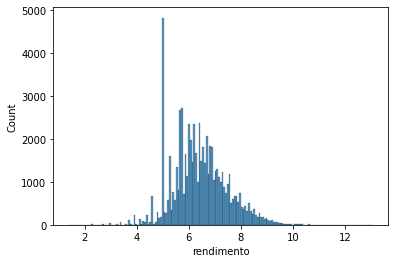

In [128]:
sns.histplot(np.log(y_train))

/home/franklin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rendimento'>

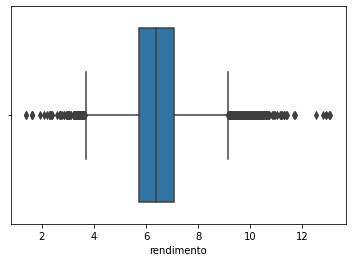

In [127]:
sns.boxplot(np.log(y_train))

In [9]:
X_train.head()

,sigla_uf,situacao_domicilio,comodos,condicao_domicilio,banheiros,moradores,homens,mulheres,agua,coleta_lixo,...,videocassete,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,pavimentacao
4576,RS,1,8.0,1.0,1.0,6,4,2,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,6,3.0
1088,SP,1,4.0,2.0,1.0,5,1,4,1.0,1.0,...,2.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,5,1.0
479,SP,1,5.0,1.0,2.0,4,1,3,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,4,1.0
727,SP,1,4.0,2.0,1.0,3,2,1,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,3,1.0
3783,RS,1,5.0,1.0,1.0,1,0,1,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1,1.0


In [10]:
X_train['comodos'].value_counts()

5.0     686
6.0     559
4.0     489
7.0     334
3.0     262
8.0     215
9.0     118
2.0     104
10.0     76
11.0     39
1.0      28
12.0     22
13.0     17
14.0     15
15.0      6
16.0      4
20.0      1
18.0      1
19.0      1
Name: comodos, dtype: int64

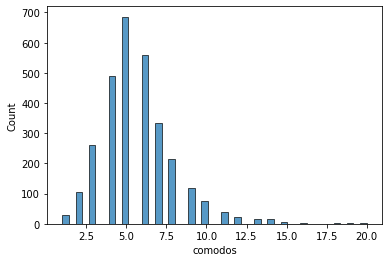

In [11]:
sns.histplot(data=X_train, x='comodos');

rendimento            1.000000
automoveis            0.530620
banheiros             0.498810
televisores           0.461778
comodos               0.391630
ar_condicionado       0.290586
mulheres              0.009481
moradores            -0.003307
iluminacao_publica   -0.003307
homens               -0.014638
condicao_domicilio   -0.075638
iluminacao           -0.111818
radio                -0.115890
pavimentacao         -0.145329
agua                 -0.145734
situacao_domicilio   -0.157563
coleta_lixo          -0.176095
geladeira            -0.193975
maquina_lavar        -0.348829
videocassete         -0.380413
telefone             -0.388146
computador           -0.439951
microondas           -0.443054
Name: rendimento, dtype: float64


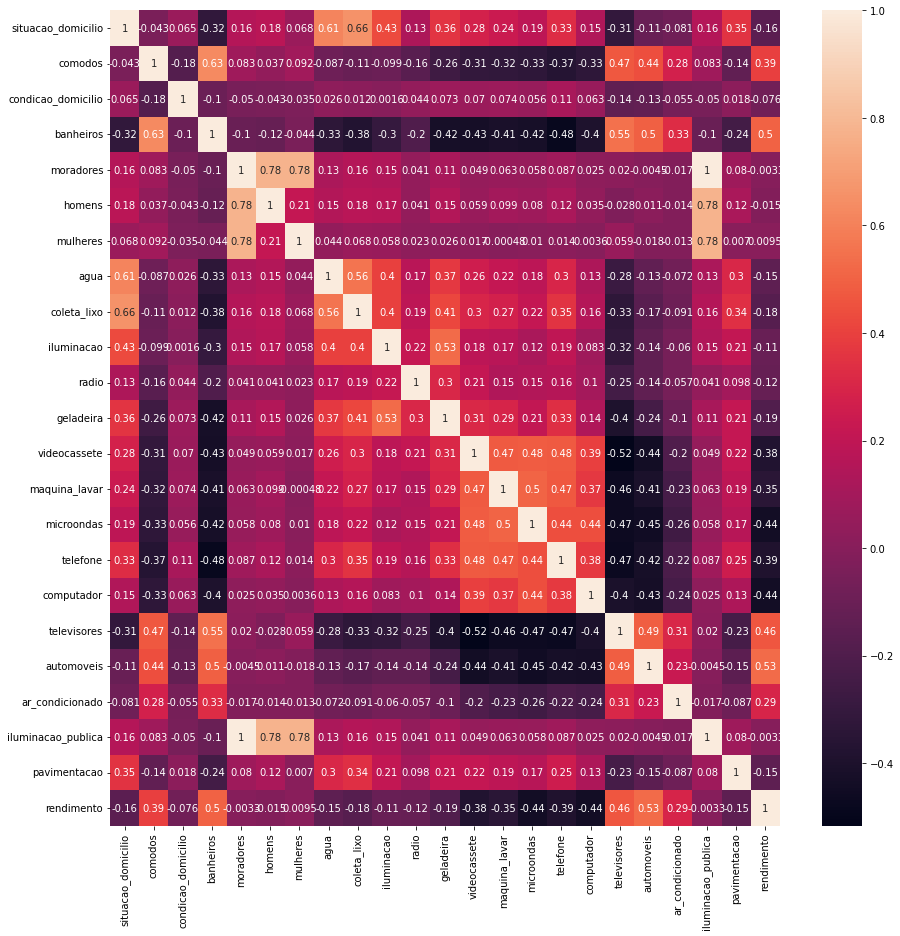

In [12]:
corr = X_train.join(y_train).corr()

plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True);

print(corr['rendimento'].sort_values(ascending=False))

## Modelos de ML

In [112]:
X_train.head()

,sigla_uf,id_municipio,situacao_domicilio,tipo_domicilio,condicao_domicilio,comodos,banheiros,agua,iluminacao,radio,...,automoveis,ar_condicionado,iluminacao_publica,pavimentacao,coleta_lixo,esgotamento,morador_dormitorio,moradores,homens,mulheres
95866,RO,1101005,rural,casa,proprio pago,9,1,2,1,1,...,0,0,5,3.0,3,3.0,1.3,5,4,1
86468,RS,4317103,urbano,casa,proprio pago,3,0,1,1,1,...,0,0,5,3.0,1,3.0,5.0,5,3,2
44599,MG,3162500,urbano,casa,alugado,7,1,1,1,1,...,1,0,4,1.0,1,1.0,2.0,4,3,1
18065,SP,3550308,urbano,casa,proprio pago,5,2,1,1,1,...,1,0,5,1.0,1,1.0,2.5,5,3,2
18609,DF,5300108,urbano,casa,alugado,3,1,2,1,1,...,0,0,2,3.0,1,3.0,2.0,2,1,1


In [14]:
# Tratamento

sim_imp = SimpleImputer(strategy='constant', fill_value=-1)
enc_ct = ColumnTransformer(transformers=[('ord_enc', ord_enc, [0])], remainder='passthrough')
std_scaler = StandardScaler()
tr_pipeline = Pipeline([('imp', sim_imp), ('enc_ct', enc_ct), ('scale', std_scaler)])

tr_pipeline

Pipeline(steps=[('imp', SimpleImputer(fill_value=-1, strategy='constant')),
                ('enc_ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_enc', OrdinalEncoder(),
                                                  [0])])),
                ('scale', StandardScaler())])

In [114]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

ValueError: could not convert string to float: 'RO'

In [15]:
# Transforming

X_train_tr = tr_pipeline.fit_transform(X_train)
X_test_tr = tr_pipeline.transform(X_test)

In [16]:
# Evaluating

lin_reg = LinearRegression()
lin_reg.fit(X_train_tr, y_train)
y_pred = lin_reg.predict(X_test_tr)

print(f'R2: {r2_score(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

R2: 0.33516729885159524
RMSE: 1686.1010601898106


In [1]:
import os
import pandas as pd
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'renda-censo-regressao-0d5cd82b3cac.json'

client = bigquery.Client()

query = """
        SELECT sigla_uf, situacao_domicilio, v0203 AS comodos, v0205 AS condicao_domicilio, v0209 AS banheiros, v7100 AS moradores, v0110 AS homens, v0111 AS mulheres,v0207 AS agua, v0212 AS coleta_lixo, v0213 AS iluminacao, v0214 AS radio, v0215 AS geladeira, v0216 AS videocassete, v0217 AS maquina_lavar, v0218 AS microondas, v0219 as telefone, v0220 as computador, v0221 as televisores, v0222 as automoveis, v0223 as ar_condicionado, v7100 as iluminacao_publica, v1113 as pavimentacao, v7616 AS rendimento
        FROM `basedosdados.br_ibge_censo_demografico.microdados_domicilio_2000`
        WHERE v7616 IS NOT NULL AND (v7616 > 0)
        ORDER BY RAND() 
        LIMIT 100;
        """

df = client.query(query).to_dataframe()

,sigla_uf,situacao_domicilio,comodos,condicao_domicilio,banheiros,moradores,homens,mulheres,agua,coleta_lixo,...,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,pavimentacao,rendimento
0,RJ,1,7,1,3,3,1,2,1,1,...,1,1,1,1,3,2,2,3,1,8800
1,SP,1,7,2,1,5,2,3,1,1,...,2,1,1,2,1,0,0,5,1,620
2,AC,1,1,1,0,1,1,0,1,1,...,2,2,2,2,0,0,0,1,2,120
3,MA,2,4,1,0,5,4,1,2,5,...,2,2,2,2,0,0,0,5,3,300
4,SP,1,6,1,2,4,2,2,1,1,...,2,1,1,2,2,2,0,4,1,930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BA,1,6,1,1,6,1,5,1,1,...,2,2,2,2,1,1,0,6,1,1281
96,BA,1,8,1,3,3,1,2,1,1,...,2,2,2,2,2,0,0,3,3,1400
97,PB,1,6,1,1,3,2,1,3,2,...,2,2,2,2,2,1,0,3,1,289
98,RS,2,5,1,1,3,2,1,1,1,...,1,2,1,1,2,1,0,3,3,1970


In [2]:
query

'\n        SELECT sigla_uf, situacao_domicilio, v0203 AS comodos, v0205 AS condicao_domicilio, v0209 AS banheiros, v7100 AS moradores, v0110 AS homens, v0111 AS mulheres,v0207 AS agua, v0212 AS coleta_lixo, v0213 AS iluminacao, v0214 AS radio, v0215 AS geladeira, v0216 AS videocassete, v0217 AS maquina_lavar, v0218 AS microondas, v0219 as telefone, v0220 as computador, v0221 as televisores, v0222 as automoveis, v0223 as ar_condicionado, v7100 as iluminacao_publica, v1113 as pavimentacao, v7616 AS rendimento\n        FROM `basedosdados.br_ibge_censo_demografico.microdados_domicilio_2000`\n        WHERE v7616 IS NOT NULL AND (v7616 > 0)\n        ORDER BY RAND() \n        LIMIT 100;\n        '